In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as pyplot
import csv
import functools 
import nltk
import random
from collections import Counter
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

### Loading Datasets 

In [43]:
imdb_df_train = pd.read_csv('./hwk3_datasets/IMDB-train.txt', delimiter="\t", header=None)
imdb_df_test = pd.read_csv('./hwk3_datasets/IMDB-test.txt',   delimiter="\t",   header=None)
imdb_df_valid = pd.read_csv('./hwk3_datasets/IMDB-valid.txt', delimiter="\t", header=None)

yelp_df_train = pd.read_csv('./hwk3_datasets/yelp-train.txt', delimiter="\t", header=None)
yelp_df_test = pd.read_csv('./hwk3_datasets/yelp-test.txt',   delimiter="\t",  header=None)
yelp_df_valid = pd.read_csv('./hwk3_datasets/yelp-valid.txt', delimiter="\t",header=None)

imdb_df_train.columns = ['review','rating']
imdb_df_test.columns = ['review','rating']
imdb_df_valid.columns = ['review','rating']
yelp_df_train.columns = ['review','rating']
yelp_df_test.columns = ['review','rating']
yelp_df_valid.columns = ['review','rating']

### Helper Functions for Preprocessing

In [3]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def preprocessor(review):
    '''
    Tokenizer using a regular expression to remove punctuation.
    Also lowercases all of the words in a review.
    '''
    return [word.lower() for word in tokenizer.tokenize(review)]
    
def create_vocab_text(df,file_name):
    '''
    Generates the <DatasetName>-vocab.txt file as
    specified by the assignment 3 guidelines. 
    '''
    df['tokenized_review'] = df['review'].apply(preprocessor)
    cnt = Counter()
    for review in df['tokenized_review']:
        for word in review:
            cnt[word] += 1
    del df['tokenized_review']
    most_common_ten_thousand = cnt.most_common(10000)
    with open(file_name,'w') as file_writer:
        writer = csv.writer(file_writer, delimiter="\t")
        for i in range(10000):
            writer.writerow([most_common_ten_thousand[i][0],i,
                             most_common_ten_thousand[i][1]])

def get_word_dict_from_file(file_path):
    '''
    Generates a dictionary of words from the assignment
    which has the following key, value pair: word -> id 
    '''
    WORD_DICT = {}
    with open(file_path) as vocab_file:
        entries = [line.strip().split("\t") for line in vocab_file]
        for word, id_word, count in entries:
            WORD_DICT[word] = id_word
    return WORD_DICT

def words_to_ids(text,word_dict=None):
    '''
    Converts a review into a list of ids, each
    id representing a word from the <Dataset name>-vocab.txt
    file.
    '''
    return [word_dict[word] for word in text if word in word_dict]

def create_review_id_csv(WORD_DICT, df, file_path, delete_id_column=True, delete_tokenized_column=True):
    '''
    Generates the <Dataset Name>-<set type>.txt file which
    contains the ids and the class of a particular review.
    '''
    df['tokenized_review'] = df['review'].apply(preprocessor)
    word_lookup_func = functools.partial(words_to_ids, word_dict=WORD_DICT)
    df['review_ids'] = df['tokenized_review'].apply(word_lookup_func)
    if delete_tokenized_column:
        del df['tokenized_review']
    with open(file_path, 'w') as review_id_file:
        writer = csv.writer(review_id_file, delimiter="\t")
        for rating, review_ids in zip(df['rating'],df['review_ids']):
            space_separated_ids = ' '.join(review_ids)
            writer.writerow([space_separated_ids, rating])
    if delete_id_column:
        del df['review_ids']  

def binary_bag_of_words_vectorizer(WORD_DICT, review):
    '''
    Generates the binary bag of words representation of a 
    review as specified in the assignment.
    '''
    review_list = set(preprocessor(review))
    vector = np.asarray([1 if key in review_list else 0 for key in WORD_DICT])
    return vector


def frequency_bag_of_words_vectorizer(WORD_DICT, review):
    '''
    Generates the frequency bag of words representation of a 
    review, as specified in the assignment. 
    '''
    review_list = preprocessor(review)
    review_list_top_words = [word for word in review_list if word in WORD_DICT]
    global_occurences = len(review_list_top_words)
    counter = Counter(review_list_top_words)
    freq_dict = {}
    for word in counter.keys():
        word_occurences = counter[word]
        frequency = float(word_occurences) / float(global_occurences)
        freq_dict[word] = frequency
    vector = np.asarray([freq_dict[word] if word in freq_dict else 0 for word in WORD_DICT])
    return vector


def get_binary_bag_vectorized_representation(WORD_DICT, df):
    training_list = []
    for review, rating in zip(df['review'], df['rating']):
        review_vector = binary_bag_of_words_vectorizer(WORD_DICT, review)
        review_vector_with_class =np.append(review_vector, rating)
        training_list.append(review_vector_with_class)
        
    return np.asarray(training_list)

def get_frequency_bag_vectorized_representation(WORD_DICT, df):
    training_list = []
    for review, rating in zip(df['review'], df['rating']):
        review_vector = frequency_bag_of_words_vectorizer(WORD_DICT, review)
        review_vector_with_class =np.append(review_vector, rating)
        training_list.append(review_vector_with_class)
    return np.asarray(training_list)
    
    


### Helper Functions for Training/Validating Models

#### Baseline Classifiers

In [4]:
def get_random_classifier(training_set):
    '''
    Will return a random choice classifier from all 
    possible labels.This assumes that the training set 
    has the class labels in the last column of a numpy 
    array. Returns a function. To classifiy, you need to
    pass a review vector.
    '''
    classes = list(set(training_set[:,-1]))
    return lambda review: random.choice(classes)

def get_majority_classifier(training_set):
    '''
    Will always return the majority. This assumes that the
    training set has the class labels in the last column
    of a numpy array. Returns a function. To classifiy, 
    you need to pass a review vector.
    '''
    classes = training_set[:,-1]
    counter = Counter(classes)
    return lambda review : counter.most_common(1)[0][0]

#### Bayes Classifiers

In [51]:
def get_bern_bayes_classifier_f1_scores(alphas, training_set, validation_set):
    '''
    Returns the f1 averages for each alpha passed in 
    the method over the target training/validation set.
    '''
    alphas = alphas
    f1_averages = []
    for alpha in alphas:
        model = BernoulliNB(alpha=alpha)
        X = training_set[:,:-1]
        Y = training_set[:,-1]
        model.fit(X, Y)
        XV = validation_set[:,:-1]
        YV = validation_set[:,-1]
        YPRED = model.predict(XV)
        f1_average = np.average(f1_score(YV,YPRED,average=None))
        f1_averages.append(f1_average)
    return f1_averages

def get_bern_bayes_classifier_f1_score(alpha, training_set, test_set):
    model = BernoulliNB(alpha=alpha)
    X = training_set[:,:-1]
    Y = training_set[:,-1]
    model.fit(X, Y)
    XT = test_set[:,:-1]
    YT = test_set[:,-1]
    YPRED = model.predict(XT)
    f1_average = np.average(f1_score(YT,YPRED,average=None))
    return f1_average

def get_naive_bayes_classifier_f1_score(training_set, test_set):
    model = GaussianNB()   
    X = training_set[:,:-1]
    Y = training_set[:,-1]
    model.fit(X, Y)
    XT = test_set[:,:-1]
    YT = test_set[:,-1]
    YPRED = model.predict(XT)
    return np.average(f1_score(YT,YPRED,average=None))
    



#### Decision Tree Classifiers

In [6]:
def get_decision_tree_classifier(param_grid, training_set, validation_set):
    dt_model = DecisionTreeClassifier()
    
    # Made an f1 average scorer out of f1_score
    scorer = make_scorer(f1_average_score)
    train_valid_set = np.concatenate([training_set,validation_set])
    test_fold = np.concatenate([np.zeros((len(training_set),)), np.full((len(validation_set),),fill_value=-1)])
    X = train_valid_set[:,:-1]
    Y = train_valid_set[:,-1]
    ps = PredefinedSplit(test_fold)
    clf = GridSearchCV(estimator=dt_model, # use the decision tree model
                   scoring=scorer, # use f1 score to determine the best
                   cv=ps, # use the predefined training/test split to determine the optimal params 
                   param_grid=param_grid, # test over the following grid
                  )
    clf.fit(X,Y)
    return clf

### SVM Classifiers

In [7]:
def get_svm_classifier(param_grid, training_set, validation_set):
    svm_model = LinearSVC()
    
    # Made an f1 average scorer out of f1_score
    scorer = make_scorer(f1_average_score)
    
    train_valid_set = np.concatenate([training_set,validation_set])
    test_fold = np.concatenate([np.zeros((len(training_set),)), np.full((len(validation_set),),fill_value=-1)])
    X = train_valid_set[:,:-1]
    Y = train_valid_set[:,-1]
    ps = PredefinedSplit(test_fold)
    clf = GridSearchCV(
                   estimator=svm_model, # use the decision tree model
                   scoring=scorer, # use f1 score to determine the best
                   cv=ps, # use the predefined training/test split to determine the optimal params 
                   param_grid=param_grid, # test over the following grid
                  )
    clf.fit(X,Y)
    return clf

### Helper Functions for Metrics

In [8]:
def get_predictions(classifier, testing_set):
    '''
    This function will iterate through a testing set
    and gather the predictions for that test set. This assumes
    that the last row in the test set is the class labels, which
    are removed and not provided as input to the classifier.
    '''
    predictions = [] 
    for sample in testing_set:
        features = sample[:-1]
        prediction = classifier(features)
        predictions.append(prediction)
    return np.array(predictions)

def f1_average_score(y, ypred, **kwargs):
    return np.average(f1_score(y,ypred,average=None,**kwargs))


## Q1.1

In [9]:
# Creating text files for dataset submission 
create_vocab_text(imdb_df_train, 'IMDB-vocab.txt')
create_vocab_text(yelp_df_train, 'YELP-vocab.txt')

IMDB_WORD_DICT = get_word_dict_from_file('IMDB-vocab.txt')
YELP_WORD_DICT = get_word_dict_from_file('YELP-vocab.txt')

create_review_id_csv(IMDB_WORD_DICT, imdb_df_train, 'IMDB-train.txt')
create_review_id_csv(IMDB_WORD_DICT, imdb_df_valid, 'IMDB-valid.txt')
create_review_id_csv(IMDB_WORD_DICT, imdb_df_test, 'IMDB-test.txt')
create_review_id_csv(YELP_WORD_DICT, yelp_df_train, 'YELP-train.txt')
create_review_id_csv(YELP_WORD_DICT, yelp_df_valid, 'YELP-valid.txt')
create_review_id_csv(YELP_WORD_DICT, yelp_df_test, 'YELP-test.txt')   

## Q1.2

Converting Yelp datasets into binary bag representation:

In [10]:
YELP_WORD_DICT = get_word_dict_from_file('YELP-vocab.txt')
yelp_training_set = get_binary_bag_vectorized_representation(YELP_WORD_DICT, yelp_df_train)
yelp_valid_set = get_binary_bag_vectorized_representation(YELP_WORD_DICT, yelp_df_valid)
yelp_test_set = get_binary_bag_vectorized_representation(YELP_WORD_DICT, yelp_df_test)

In [11]:
# Initializing classifiers for baseline estimates 
majority_classifier = get_majority_classifier(yelp_training_set)
random_classifier = get_random_classifier(yelp_training_set)

# Test classes vector 
test_classes = yelp_test_set[:,-1]

# Get the predictions from each baseline classifier 
random_classifier_predictions_test = get_predictions(random_classifier, yelp_test_set)
majority_classifier_predictions_test = get_predictions(majority_classifier, yelp_test_set)

# Print F1 Score for each classifier
print("\nRandom Classifier F1 Score\n")
print(f1_average_score(test_classes, random_classifier_predictions_test))
print("\nMajority Classifier F1 Score\n")
print(f1_average_score(test_classes, majority_classifier_predictions_test))


Random Classifier F1 Score

0.185493120855

Majority Classifier F1 Score

0.103923019985


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Bernoulli Naive Bayes Classifier

#### Hyperparameter tuning over various alphas

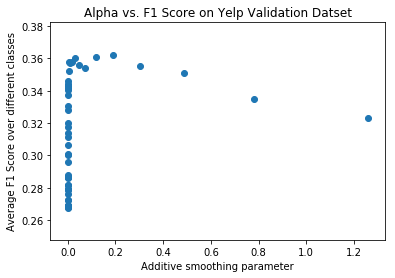

The maximum alpha was 0.18859 and the F1 average was 0.36243

Alphas Tested:

[  1.00000000e-10   1.60739439e-10   2.58371673e-10   4.15305179e-10
   6.67559216e-10   1.07303094e-09   1.72478392e-09   2.77240800e-09
   4.45635307e-09   7.16311693e-09   1.15139540e-08   1.85074651e-08
   2.97487956e-08   4.78180472e-08   7.68624610e-08   1.23548289e-07
   1.98590827e-07   3.19213781e-07   5.13102442e-07   8.24757988e-07
   1.32571137e-06   2.13094102e-06   3.42526264e-06   5.50574796e-06
   8.84990840e-06   1.42252931e-05   2.28656564e-05   3.67541279e-05
   5.90783791e-05   9.49622553e-05   1.52641797e-04   2.45355568e-04
   3.94383164e-04   6.33929287e-04   1.01897438e-03   1.63789371e-03
   2.63274116e-03   4.23185338e-03   6.80225739e-03   1.09339104e-02
   1.75751062e-02   2.82501272e-02   4.54090961e-02   7.29903265e-02
   1.17324241e-01   1.88586328e-01   3.03132606e-01   4.87253651e-01
   7.83208787e-01   1.25892541e+00]


In [12]:
alphas = np.logspace(-10,0.1)
f1_scores = get_bern_bayes_classifier_f1_scores(alphas, yelp_training_set, yelp_valid_set)

pyplot.scatter(alphas,f1_scores)
pyplot.title("Alpha vs. F1 Score on Yelp Validation Datset")
pyplot.xlabel("Additive smoothing parameter")
pyplot.ylabel("Average F1 Score over different classes")
pyplot.show()

max_alpha = max(zip(alphas,f1_scores),key=lambda x : x[1])
print("The maximum alpha was %.5f and the F1 average was %.5f"%max_alpha)
print("\nAlphas Tested:\n")
print(alphas)


#### Test set performance

In [13]:
f1_average = get_bern_bayes_classifier_f1_score(max_alpha[0],yelp_training_set, yelp_test_set)
print("The F1 Average on the Test Set is %.5f"%(f1_average))

The F1 Average on the Test Set is 0.38626


### Decision Tree Classifier

In [89]:
param_grid = {
              'max_depth':[21,23,25,27]
             }

clf = get_decision_tree_classifier(param_grid,yelp_training_set, yelp_valid_set)



In [90]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.26405 and came with the parameters: {'max_depth': 25}


In [91]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_decision_tree_classifier(best_param_grid, yelp_training_set, yelp_test_set)

In [92]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.28743


### Linear SVM Classifier

In [18]:
param_grid = {
                "C": np.linspace(0.001,0.1,5),
             }
svm_model = LinearSVC()
clf = get_svm_classifier(param_grid, yelp_training_set, yelp_valid_set)



In [19]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.38885 and came with the parameters: {'C': 0.025750000000000002}


In [20]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_svm_classifier(best_param_grid, yelp_training_set, yelp_test_set)

In [21]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.39838


### 1.3 

Converting Yelp datasets using frequency bag of words representation

In [22]:
YELP_WORD_DICT = get_word_dict_from_file('YELP-vocab.txt')
yelp_training_set_freq = get_frequency_bag_vectorized_representation(YELP_WORD_DICT, yelp_df_train)
yelp_valid_set_freq = get_frequency_bag_vectorized_representation(YELP_WORD_DICT, yelp_df_valid)
yelp_test_set_freq = get_frequency_bag_vectorized_representation(YELP_WORD_DICT, yelp_df_test)

### Gaussian Naive Bayes Classifier

In [23]:
f1_score_validation = get_naive_bayes_classifier_f1_score(yelp_training_set_freq, yelp_valid_set_freq)
f1_score_test = get_naive_bayes_classifier_f1_score(yelp_training_set_freq, yelp_test_set_freq)
print("The validation score was %.5f and the test score was %.5f"%(f1_score_test, f1_score_validation))

The validation score was 0.25787 and the test score was 0.25265


### Decision Tree Classifier

In [24]:
param_grid = {
              'max_depth':[3,5,7,9,11]
             }

clf = get_decision_tree_classifier(param_grid,yelp_training_set_freq, yelp_valid_set_freq)

In [25]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.28047 and came with the parameters: {'max_depth': 9}


In [26]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_decision_tree_classifier(best_param_grid, yelp_training_set_freq, yelp_test_set_freq)

In [27]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.23470


### Linear SVM Classifier

In [28]:
param_grid = {"C": np.logspace(2,2.5,4)}
svm_model = LinearSVC()
clf = get_svm_classifier(param_grid, yelp_training_set_freq, yelp_valid_set_freq)


In [29]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.38448 and came with the parameters: {'C': 215.44346900318845}


In [30]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_svm_classifier(best_param_grid, yelp_training_set_freq, yelp_test_set_freq)

In [31]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.39658


### 1.4

Converting IMDB datasets using binary bag of words representation and frequency bag of words representation.

In [32]:
IMDB_WORD_DICT = get_word_dict_from_file('IMDB-vocab.txt')
imdb_training_set = get_binary_bag_vectorized_representation(IMDB_WORD_DICT, imdb_df_train)
imdb_valid_set = get_binary_bag_vectorized_representation(IMDB_WORD_DICT, imdb_df_valid)
imdb_test_set = get_binary_bag_vectorized_representation(IMDB_WORD_DICT, imdb_df_test)
imdb_training_set_freq = get_frequency_bag_vectorized_representation(IMDB_WORD_DICT, imdb_df_train)
imdb_valid_set_freq = get_frequency_bag_vectorized_representation(IMDB_WORD_DICT, imdb_df_valid)
imdb_test_set_freq = get_frequency_bag_vectorized_representation(IMDB_WORD_DICT, imdb_df_test)

In [11]:
# Initializing classifiers for baseline estimates 
majority_classifier = get_majority_classifier(imdb_training_set)
random_classifier = get_random_classifier(imdb_training_set)

# Test classes vector 
test_classes = imdb_test_set[:,-1]

# Get the predictions from each baseline classifier 
random_classifier_predictions_test = get_predictions(random_classifier, imdb_test_set)
majority_classifier_predictions_test = get_predictions(majority_classifier, imdb_test_set)

# Print F1 Score for each classifier
print("\nRandom Classifier F1 Score\n")
print(f1_average_score(test_classes, random_classifier_predictions_test))
print("\nMajority Classifier F1 Score\n")
print(f1_average_score(test_classes, majority_classifier_predictions_test))


Random Classifier F1 Score

0.185493120855

Majority Classifier F1 Score

0.103923019985


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Binary Bag of Words

#### Bernoulli Naive Bayes

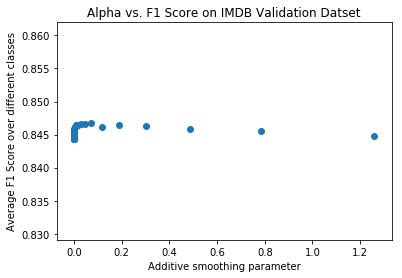

The maximum alpha was 0.07299 and the F1 average was 0.84668

Alphas Tested:

[  1.00000000e-10   1.60739439e-10   2.58371673e-10   4.15305179e-10
   6.67559216e-10   1.07303094e-09   1.72478392e-09   2.77240800e-09
   4.45635307e-09   7.16311693e-09   1.15139540e-08   1.85074651e-08
   2.97487956e-08   4.78180472e-08   7.68624610e-08   1.23548289e-07
   1.98590827e-07   3.19213781e-07   5.13102442e-07   8.24757988e-07
   1.32571137e-06   2.13094102e-06   3.42526264e-06   5.50574796e-06
   8.84990840e-06   1.42252931e-05   2.28656564e-05   3.67541279e-05
   5.90783791e-05   9.49622553e-05   1.52641797e-04   2.45355568e-04
   3.94383164e-04   6.33929287e-04   1.01897438e-03   1.63789371e-03
   2.63274116e-03   4.23185338e-03   6.80225739e-03   1.09339104e-02
   1.75751062e-02   2.82501272e-02   4.54090961e-02   7.29903265e-02
   1.17324241e-01   1.88586328e-01   3.03132606e-01   4.87253651e-01
   7.83208787e-01   1.25892541e+00]


In [33]:
alphas = np.logspace(-10,0.1)
f1_scores = get_bern_bayes_classifier_f1_scores(alphas, imdb_training_set, imdb_valid_set)

pyplot.scatter(alphas,f1_scores)
pyplot.title("Alpha vs. F1 Score on IMDB Validation Datset")
pyplot.xlabel("Additive smoothing parameter")
pyplot.ylabel("Average F1 Score over different classes")
pyplot.show()

max_alpha = max(zip(alphas,f1_scores),key=lambda x : x[1])
print("The maximum alpha was %.5f and the F1 average was %.5f"%max_alpha)
print("\nAlphas Tested:\n")
print(alphas)

In [52]:
f1_scores_test = get_bern_bayes_classifier_f1_score(max_alpha[0], imdb_training_set, imdb_test_set)

0.834045418219


In [53]:
print("The F1 score on the test set using the best parameters was: %.5f"%(f1_scores_test,))

The F1 score on the test set using the best parameters was: 0.83405


#### Decision Trees

In [99]:
param_grid = {
              'max_depth':[15,17,19,21]
             }

clf = get_decision_tree_classifier(param_grid,imdb_training_set, imdb_valid_set)

In [100]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.71759 and came with the parameters: {'max_depth': 15}


In [101]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_decision_tree_classifier(best_param_grid, imdb_training_set, imdb_test_set)

In [102]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.73266


#### Linear SVM

In [58]:
param_grid = {
                "C": np.logspace(-5,1,4),
                "dual":[False] # samples > features
             }
svm_model = LinearSVC()
clf = get_svm_classifier(param_grid, imdb_training_set, imdb_valid_set)

In [59]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.86558 and came with the parameters: {'C': 0.001, 'dual': False}


In [60]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_svm_classifier(best_param_grid, imdb_training_set, imdb_test_set)

In [61]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.87965


### Frequency Bag of Words

#### Gaussian Naive Bayes

In [62]:
f1_score_validation = get_naive_bayes_classifier_f1_score(imdb_training_set_freq, imdb_valid_set_freq)
f1_score_test = get_naive_bayes_classifier_f1_score(imdb_training_set_freq, imdb_test_set_freq)

print("The validation score was %.5f and the test score was %.5f"%(f1_score_test, f1_score_validation))

The validation score was 0.67888 and the test score was 0.75175


#### Decision Trees

In [63]:
param_grid = {
              'max_depth':[3,5,7,9,11]
             }

clf = get_decision_tree_classifier(param_grid, imdb_training_set_freq, imdb_valid_set_freq)

In [64]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.70523 and came with the parameters: {'max_depth': 9}


In [65]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_decision_tree_classifier(best_param_grid, imdb_training_set_freq, imdb_test_set_freq)

In [66]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.70215


#### Linear SVM

In [67]:
param_grid = {
                "C": np.logspace(2,2.5,4),
                "dual":[False] # samples > features 
             }

# C: Controls how much we want to avoid misclassifying. In the case of the IMDB dataset we really want to avoid since it's a binary problem.


clf = get_svm_classifier(param_grid, imdb_training_set_freq, imdb_valid_set_freq)

In [68]:
print("The best F1 score was %.5f and came with the parameters: %s"%(clf.best_score_,clf.best_params_))

The best F1 score was 0.87886 and came with the parameters: {'C': 146.77992676220691, 'dual': False}


In [69]:
best_param_grid = {}
for param in clf.best_params_:
    best_param_grid[param] = [clf.best_params_[param]]

clf = get_svm_classifier(best_param_grid, imdb_training_set_freq, imdb_test_set_freq)

In [70]:
print("The F1 score on the test set using the best parameters was: %.5f"%(clf.best_score_,))

The F1 score on the test set using the best parameters was: 0.88026
